In [1]:
import os
import pickle

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
stat_test_name = "test_mnist_mia_final"

stat_tests_path = "stat_tests"
stat_test_path = os.path.join(stat_tests_path, stat_test_name)
if not os.path.exists(stat_test_path):
    raise FileNotFoundError(f"Stat test path {stat_test_path} does not exist.")

init_params_path = os.path.join(stat_test_path, "init_params.pkl")
test_params_path = os.path.join(stat_test_path, "test_params.pkl")

with open(init_params_path, "rb") as f:
    init_params = pickle.load(f)
with open(test_params_path, "rb") as f:
    test_params = pickle.load(f)

print("Init params:")
for k, v in init_params.items():
    print(f"{k}: {v}")

num_tests = init_params["num_tests"]

tests_results = []  # 2-dim list [idx of repeated test][idx of test]
for i in range(num_tests):
    test_path = os.path.join(stat_test_path, f"test_{i}")
    test_result_path = os.path.join(test_path, "test_results.pkl")
    with open(test_result_path, "rb") as f:
        test_result = pickle.load(f)
    tests_results.append(test_result)

Init params:
test_name: test_mnist_mia_final
seed: 42
run_mia: True
mia_classifier_type: nn
mia_batch_size: 128
dataset_name: mnist
num_clients: 5
num_classes: 10
distribution_type: random
model_name: simple_cnn
loss_name: cross_entropy
trainer_name: sgd
lr: 0.01
momentum: 0.9
train_batch_size: 64
eval_batch_size: 128
train_epochs: 5
info_batch_size: 10
info_use_converter: False
target_client: 0
num_tests: 10


In [3]:
subtest = 0

subtest_params = []
subtest_results = []    # 2-dim list [idx of test][idx of repeated test]
for i, test_param in enumerate(test_params):
    if test_param["subtest"] == subtest:
        subtest_params.append(test_param)
        subtest_results.append([])
        for j in range(num_tests):
            subtest_results[-1].append(tests_results[j][i])

print("Subtest params:")
for key, value in subtest_params[0].items():
    if key == "unlearning_percentage":
        continue
    print(f"{key}: {value}")

print(f"Available results:")
for key in subtest_results[0][0].keys():
    print(key)

Subtest params:
subtest: 0
unlearning_method: information
retrain_epochs: 1
Available results:
total_individual_reset_params
trained_test_accuracy
trained_target_accuracy
trained_clients_accuracies
trained_class_accuracies
benchmark_test_accuracy
benchmark_target_accuracy
benchmark_clients_accuracies
benchmark_class_accuracies
reset_test_accuracy
reset_target_accuracy
reset_clients_accuracies
reset_class_accuracies
retrained_test_accuracy
retrained_target_accuracy
retrained_clients_accuracies
retrained_class_accuracies
trained_mia_auc
trained_mia_acc
reset_mia_auc
reset_mia_acc
retrained_mia_auc
retrained_mia_acc


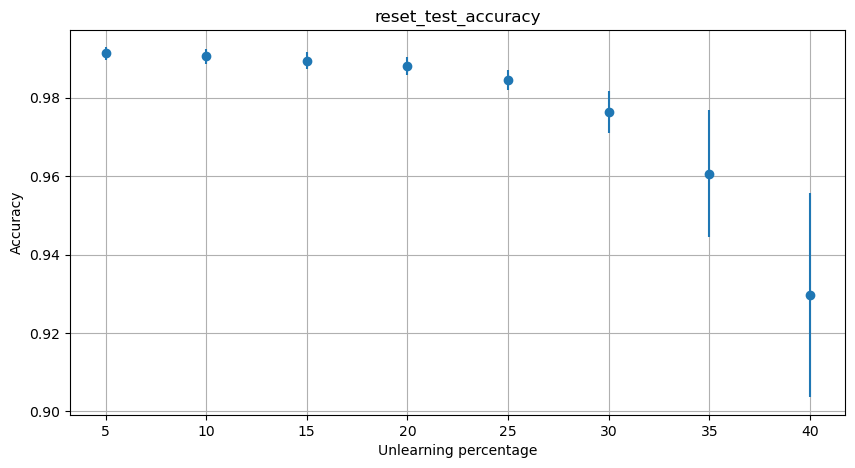

In [4]:
percentages = []
for test_param in subtest_params:
    percentages.append(test_param["unlearning_percentage"])

key = "reset_test_accuracy"
test_accuracies_avg = []
test_accuracies_std = []
for results in subtest_results:
    test_accuracies = [results[i][key] for i in range(num_tests)]
    test_accuracies_avg.append(np.mean(test_accuracies))
    test_accuracies_std.append(np.std(test_accuracies))

# Test accuracies plot
plt.figure(figsize=(10, 5))
plt.errorbar(percentages, test_accuracies_avg, yerr=test_accuracies_std, fmt='o')
plt.title(key)
plt.xlabel("Unlearning percentage")
plt.ylabel("Accuracy")
plt.xticks(percentages)
plt.grid()

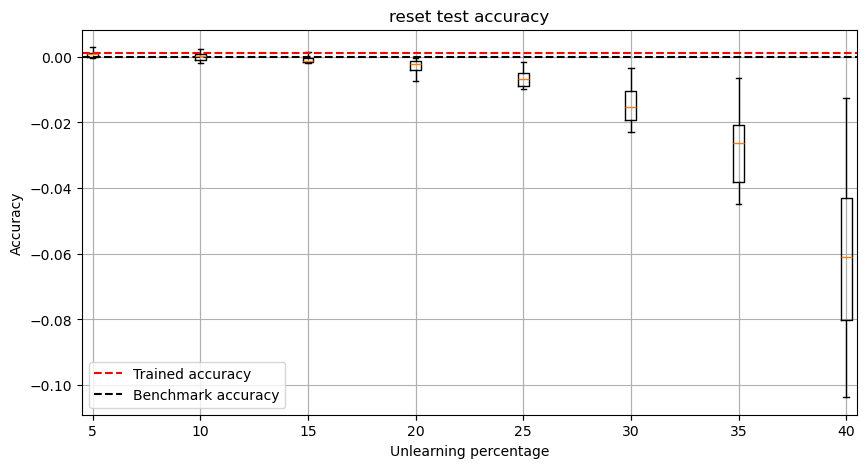

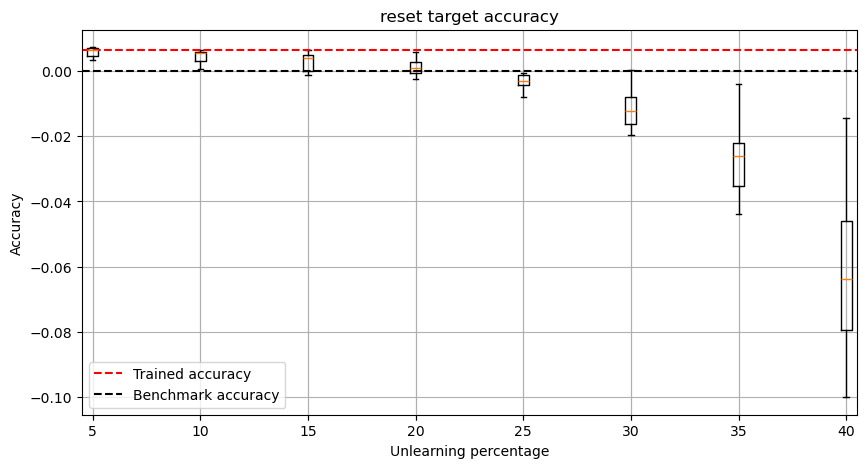

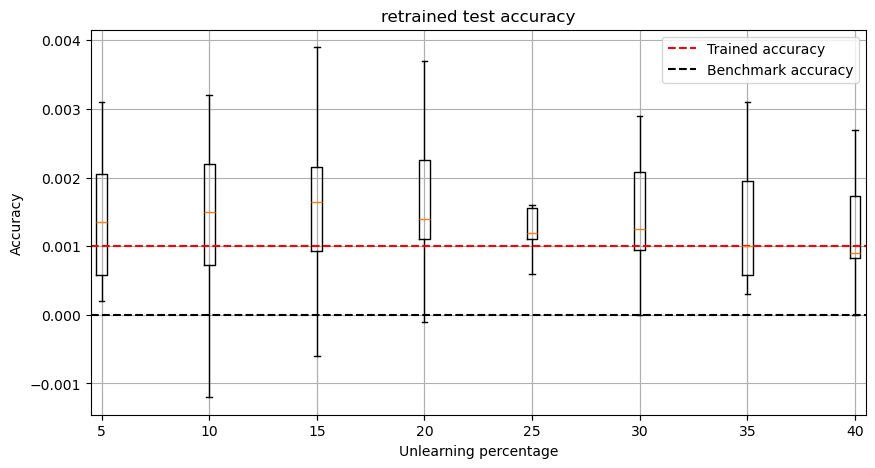

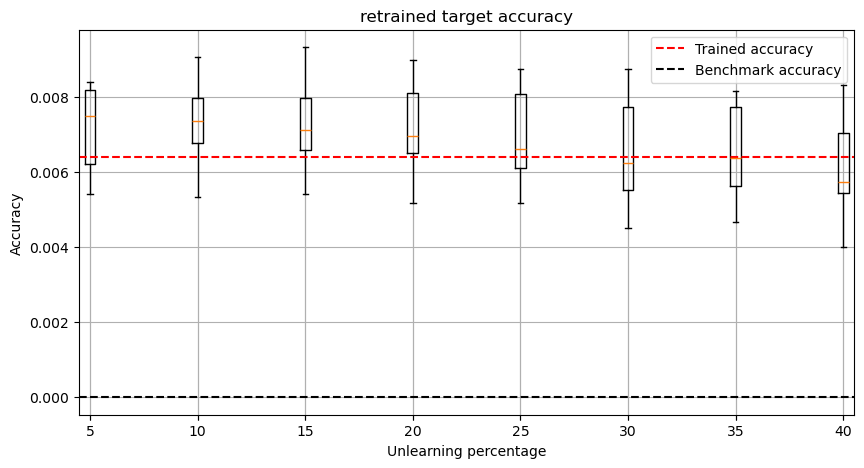

In [5]:
percentages = []
for test_param in subtest_params:
    percentages.append(test_param["unlearning_percentage"])

#percentages = percentages[:-8]

lines = ["reset", "retrained"]

for j, model in enumerate(lines):
    plt.figure(j, figsize=(10, 5))
    plt.title(f"{model} test accuracy")
    plt.xlabel("Unlearning percentage")
    plt.ylabel("Accuracy")
    plt.xticks(percentages)
    plt.grid()

    plt.figure(len(lines) + j, figsize=(10, 5))
    plt.title(f"{model} target accuracy")
    plt.xlabel("Unlearning percentage")
    plt.ylabel("Accuracy")
    plt.xticks(percentages)
    plt.grid()
    
    delta_trained_accuracy = results[0][f"trained_test_accuracy"] - results[0]["benchmark_test_accuracy"]
    delta_target_accuracy = results[0][f"trained_target_accuracy"] - results[0]["benchmark_target_accuracy"]

    delta_test_accuracies = []
    delta_target_accuracies = []
    for i in range(len(percentages)):
        results = subtest_results[i]
        benchmark_test_accuracies = [results[i]["benchmark_test_accuracy"] for i in range(num_tests)]
        benchmark_target_accuracies = [results[i]["benchmark_target_accuracy"] for i in range(num_tests)]
        model_test_accuracies = [results[i][f"{model}_test_accuracy"] for i in range(num_tests)]
        model_target_accuracies = [results[i][f"{model}_target_accuracy"] for i in range(num_tests)]
        delta_test_accuracies.append([model_test_accuracies[i] - benchmark_test_accuracies[i] for i in range(num_tests)])
        delta_target_accuracies.append([model_target_accuracies[i] - benchmark_target_accuracies[i] for i in range(num_tests)])
    
    # delta_test_accuracies_avg = [np.mean(delta_test_accuracies[i]) for i in range(len(delta_test_accuracies))]
    # delta_test_accuracies_std = [np.std(delta_test_accuracies[i]) for i in range(len(delta_test_accuracies))]
    # delta_target_accuracies_avg = [np.mean(delta_target_accuracies[i]) for i in range(len(delta_target_accuracies))]
    # delta_target_accuracies_std = [np.std(delta_target_accuracies[i]) for i in range(len(delta_target_accuracies))]

    # plt.figure(1)
    # plt.errorbar(percentages, delta_test_accuracies_avg, yerr=delta_test_accuracies_std, fmt='o', label=line)
    # plt.figure(2)
    # plt.errorbar(percentages, delta_target_accuracies_avg, yerr=delta_target_accuracies_std, fmt='o', label=line)
    plt.figure(j)
    plt.boxplot(delta_test_accuracies, positions=percentages, widths=0.5, showfliers=False)
    plt.axhline(y=delta_trained_accuracy, color='r', linestyle='--', label="Trained accuracy")
    plt.axhline(y=0, color='k', linestyle='--', label="Benchmark accuracy")
    plt.legend()

    plt.figure(len(lines) + j)
    plt.boxplot(delta_target_accuracies, positions=percentages, widths=0.5, showfliers=False)
    plt.axhline(y=delta_target_accuracy, color='r', linestyle='--', label="Trained accuracy")
    plt.axhline(y=0, color='k', linestyle='--', label="Benchmark accuracy")
    plt.legend()


    

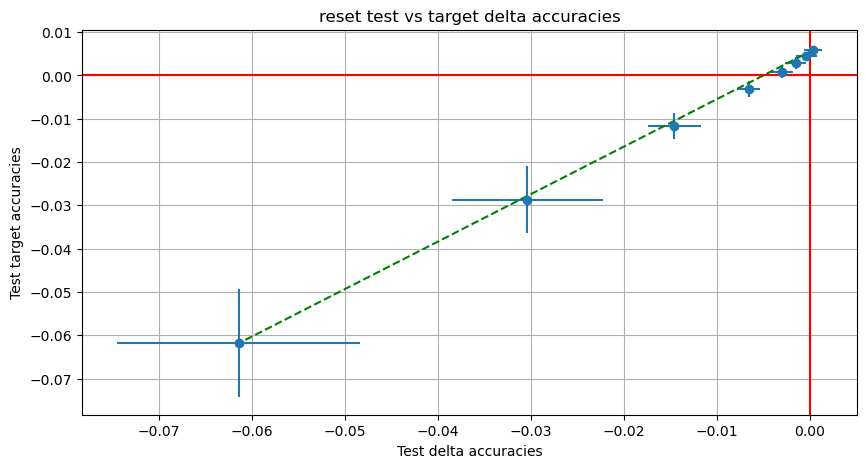

In [ ]:
percentages = []
for test_param in subtest_params:
    percentages.append(test_param["unlearning_percentage"])


model = "reset"

plt.figure(figsize=(10, 5))
plt.title(f"{model} test vs target delta accuracies")
plt.xlabel("Test delta accuracies")
plt.ylabel("Test target accuracies")
plt.grid()

delta_test_accuracies = []
delta_target_accuracies = []
for i in range(len(percentages)):
    results = subtest_results[i]
    benchmark_test_accuracies = [results[i]["benchmark_test_accuracy"] for i in range(num_tests)]
    benchmark_target_accuracies = [results[i]["benchmark_target_accuracy"] for i in range(num_tests)]
    model_test_accuracies = [results[i][f"{model}_test_accuracy"] for i in range(num_tests)]
    model_target_accuracies = [results[i][f"{model}_target_accuracy"] for i in range(num_tests)]
    delta_test_accuracies.append([model_test_accuracies[i] - benchmark_test_accuracies[i] for i in range(num_tests)])
    delta_target_accuracies.append([model_target_accuracies[i] - benchmark_target_accuracies[i] for i in range(num_tests)])

delta_test_accuracies_avg = [np.mean(delta_test_accuracies[i]) for i in range(len(delta_test_accuracies))]
delta_test_accuracies_std = [np.std(delta_test_accuracies[i])/2 for i in range(len(delta_test_accuracies))]
delta_target_accuracies_avg = [np.mean(delta_target_accuracies[i]) for i in range(len(delta_target_accuracies))]
delta_target_accuracies_std = [np.std(delta_target_accuracies[i])/2 for i in range(len(delta_target_accuracies))]

plt.errorbar(delta_test_accuracies_avg, delta_target_accuracies_avg, xerr=delta_test_accuracies_std, yerr=delta_target_accuracies_std, fmt='o')

x_variation = delta_target_accuracies_avg[0] - delta_target_accuracies_avg[-1]
xs = [delta_test_accuracies_avg[0], delta_test_accuracies_avg[-1]]
ys = [delta_target_accuracies_avg[0], delta_target_accuracies_avg[0] - x_variation]
plt.plot(xs, ys, color='g', linestyle='--')
plt.axhline(0, color='r', linestyle='-')
plt.axvline(0, color='r', linestyle='-')



    

2025-05-05 10:04:58,941 - INFO - Percentages to plot: [ 5 10 15 20 25 30 35 40]


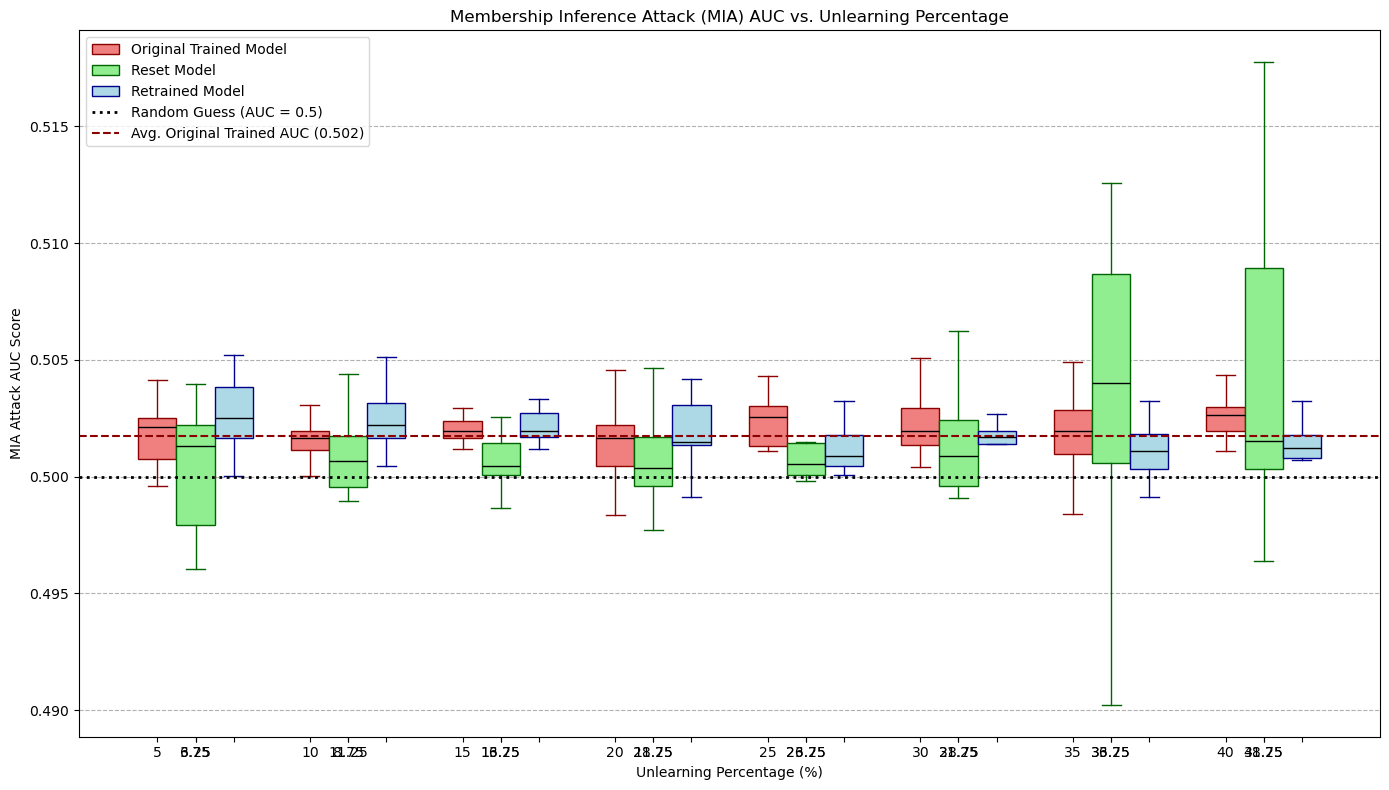

In [ ]:
subtest_params = test_params

perc_idx_pairs = sorted([(p['unlearning_percentage'], i) for i, p in enumerate(subtest_params)])
percentages = np.array([p[0] for p in perc_idx_pairs])
original_indices = [p[1] for p in perc_idx_pairs]

trained_mia_aucs_by_percentage = []
retrained_mia_aucs_by_percentage = []
resetted_mia_aucs_by_percentage = []

for _, original_idx in perc_idx_pairs: 
    current_perc_trained_aucs = []
    current_perc_retrained_aucs = []
    current_perc_resetted_aucs = []
    for j in range(num_tests):
        result_dict = tests_results[j][original_idx]

        trained_auc = result_dict.get('trained_mia_auc', np.nan)
        retrained_auc = result_dict.get('retrained_mia_auc', np.nan)
        resetted_auc = result_dict.get('reset_mia_auc', np.nan)

        current_perc_trained_aucs.append(trained_auc)
        current_perc_retrained_aucs.append(retrained_auc)
        current_perc_resetted_aucs.append(resetted_auc)

    trained_mia_aucs_by_percentage.append(current_perc_trained_aucs)
    retrained_mia_aucs_by_percentage.append(current_perc_retrained_aucs)
    resetted_mia_aucs_by_percentage.append(current_perc_resetted_aucs)

# --- Calculate Average Trained MIA AUC ---
avg_trained_mia_auc = np.mean(trained_mia_aucs_by_percentage[0])

plt.figure(figsize=(14, 8))
plt.title("Membership Inference Attack (MIA) AUC vs. Unlearning Percentage")
plt.xlabel("Unlearning Percentage (%)")
plt.ylabel("MIA Attack AUC Score")
plt.xticks(percentages)
plt.grid(axis='y', linestyle='--')

if len(percentages) > 1:
    delta_p = np.min(np.diff(percentages))
    box_width = delta_p / 4
elif len(percentages) == 1:
     box_width = 0.5 
else:
     box_width = 0 

if box_width > 0:
    pos_trained = percentages - box_width
    pos_resetted = percentages
    pos_retrained = percentages + box_width

    bp_trained = plt.boxplot(trained_mia_aucs_by_percentage, positions=pos_trained, widths=box_width, patch_artist=True, showfliers=False, medianprops=dict(color="black"), boxprops=dict(facecolor="lightcoral", color="darkred"), whiskerprops=dict(color="darkred"), capprops=dict(color="darkred"))
    bp_resetted = plt.boxplot(resetted_mia_aucs_by_percentage, positions=pos_resetted, widths=box_width, patch_artist=True, showfliers=False, medianprops=dict(color="black"), boxprops=dict(facecolor="lightgreen", color="darkgreen"), whiskerprops=dict(color="darkgreen"), capprops=dict(color="darkgreen"))
    bp_retrained = plt.boxplot(retrained_mia_aucs_by_percentage, positions=pos_retrained, widths=box_width, patch_artist=True, showfliers=False, medianprops=dict(color="black"), boxprops=dict(facecolor="lightblue", color="darkblue"), whiskerprops=dict(color="darkblue"), capprops=dict(color="darkblue"))

    line_random, = plt.plot([], [], color='black', linestyle=':', linewidth=2, label='Random Guess (AUC = 0.5)')
    line_trained_avg, = plt.plot([], [], color='darkred', linestyle='--', linewidth=1.5, label=f'Avg. Original Trained AUC ({avg_trained_mia_auc:.3f})')
    plt.axhline(y=0.5, color='black', linestyle=':', linewidth=2)
    plt.axhline(y=avg_trained_mia_auc, color='darkred', linestyle='--', linewidth=1.5)

    plt.legend(handles=[bp_trained["boxes"][0], bp_resetted["boxes"][0], bp_retrained["boxes"][0], line_random, line_trained_avg],
               labels=['Original Trained Model', 'Reset Model', 'Retrained Model', 'Random Guess (AUC = 0.5)', f'Avg. Original Trained AUC ({avg_trained_mia_auc:.3f})'],
               loc='best')
else:
    plt.text(0.5, 0.5, 'No data to plot', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()
